In [201]:
# https://docs.python.org/3/library/sys.html
import sys
# https://docs.python.org/3/library/hashlib.html#hash-algorithms
import hashlib
# https://pymultihash.readthedocs.io/en/latest/#
import multihash
# https://py-multicodec.readthedocs.io/en/stable/
from multicodec import add_prefix, remove_prefix, get_codec
# https://github.com/multiformats/py-multibase
import multibase
# https://github.com/parrt/lolviz
from lolviz import *
# https://github.com/parrt/lolviz#preferencess
prefs.max_str_len = 64
# https://github.com/parrt/lolviz/blob/master/examples.ipynb
from IPython.display import display
# https://bitstring.readthedocs.io/en/latest/index.html
from bitstring import Bits, BitArray, BitStream, ConstBitStream
# https://github.com/ilanschnell/bitarray
from bitarray import bitarray
from bitarray.util import int2ba, ba2int, strip
# https://github.com/multiformats/unsigned-varint
import varint
# https://github.com/tqdm/tqdm
from tqdm import tqdm

In [202]:
# минимально необходимая длина для переданного целого
def bitLen(intValue):
    # работаем только с положительными целыми числами
    if intValue < 0:
        raise Exception("Only unsigned integers allowed")
    # для представления нуля все равно нужен 1 бит
    if intValue == 0:
        return 1
    length = 0
    while (intValue):
        intValue >>= 1
        length += 1
    return(length)

for i in range(17):
     print(i, ':', bitLen(i))

0 : 1
1 : 1
2 : 2
3 : 2
4 : 3
5 : 3
6 : 3
7 : 3
8 : 4
9 : 4
10 : 4
11 : 4
12 : 4
13 : 4
14 : 4
15 : 4
16 : 5


In [203]:
# compute hash block bytes or load it from menory
def getHashBlock(nounce, type="sha512"):
    nounceHash = hashlib.sha512(varint.encode(nounce)).digest()
    return Bits(bytes=nounceHash)

print(getHashBlock(1), len(getHashBlock(1)))
print(getHashBlock(2), len(getHashBlock(2)))

0x7b54b66836c1fbdd13d2441d9e1434dc62ca677fb68f5fe66a464baadecdbd00576f8d6b5ac3bcc80844b7d50b1cc6603444bbe7cfcf8fc0aa1ee3c636d9e339 512
0xfab848c9b657a853ee37c09cbfdd149d0b3807b191dde9b623ccd95281dd18705b48c89b1503903845bba5753945351fe6b454852760f73529cf01ca8f69dcca 512


In [204]:
# вычислить два соседних блока хешей - чтобы можно было искать значения которые находятся на стыке блоков
def getExtendedHashBlock(nounce, type="sha512"):
    currentBlock = getHashBlock(nounce, type)
    nextBlock    = getHashBlock(nounce + 1, type)
    # prevBlock    = getHashBlock(nounce - 1, type)
    return (currentBlock + nextBlock)
print(getExtendedHashBlock(1), len(getExtendedHashBlock(1)))

0x7b54b66836c1fbdd13d2441d9e1434dc62ca677fb68f5fe66a464baadecdbd00576f8d6b5ac3bcc80844b7d50b1cc6603444bbe7cfcf8fc0aa1ee3c636d9e339fab848c9b657a853ee37c09cbfdd149d0b3807b191dde9b623ccd95281dd18705b48c89b1503903845bba5753945351fe6b454852760f73529cf01ca8f... 1024


In [205]:
# получить часть пространства хешей двух соседних блоков в котором может находится указанное значение
def getSearchHashBlock(nounce, value):
    valueLength  = len(value)
    blockLength  = 512
    hashBlock = getExtendedHashBlock(nounce)
    # получаем длину пространства хешей двух смежных блоков в котором может располагаться значение
    searchLength = blockLength + valueLength - 1
    return hashBlock[0:searchLength]

In [206]:
# найти значение битовой последовательности внутри блока
def findValueInBlock(nounce, value, count=1, normalize=False, bytealigned=False, start=0):
    # нормализуем переданное значение, убирая лишние нули в старших битах
    if (normalize == True):
        value = normalizeBinaryValue(value)
    # добавляем несколько бит из соседнего блока чтобы можно было искать значения на стыке блоков
    hashBlock = getSearchHashBlock(nounce, value)
    return list(hashBlock.findall(value, start=start, count=count, bytealigned=bytealigned))

testSearchHashBlock = getSearchHashBlock(1, Bits('0x39fa'))
print(testSearchHashBlock, len(testSearchHashBlock))
testFindValueInBlock = findValueInBlock(1, Bits('0x39fa'))
print(testFindValueInBlock)
print(Bits('0x39fa').bin, len(Bits('0x39fa')))

0x7b54b66836c1fbdd13d2441d9e1434dc62ca677fb68f5fe66a464baadecdbd00576f8d6b5ac3bcc80844b7d50b1cc6603444bbe7cfcf8fc0aa1ee3c636d9e339fab, 0b100 527
[504]
0011100111111010 16


In [207]:
# получить значение из блока хешей
def readValueFromBlock(nounce, start, length):
    end = start + length
    hashBlock = getExtendedHashBlock(nounce)
    return hashBlock[start:end]

testValueStartsBlock1EndsBlock2 = Bits('0x39fa') 
print(testValueStartsBlock1EndsBlock2)
print(readValueFromBlock(1, 504, 16))

0x39fa
0x39fa


In [208]:
# найти значение в пространстве хешей, в рамках указанного диапазона блоков
# эта функция возвращает все позиции бит в блоке, с которых начинается переданное значение
def findValueInHashes(value, fromNounce, toNounce, normalize=False, bytealigned=False):
    # сохраняем переданное значение и его длину до нормализации
    inputValue       = Bits(value)
    inputValueLength = len(inputValue)
    # нормализуем переданное значение, убирая лишние нули в старших битах
    if (normalize == True):
        value = normalizeBinaryValue(value)
    # вычисляем длину найденного значения чтобы корректно вычислить координаты для чтения
    valueLength = len(value)
    # размер одного блока хеша в битах
    blockSize     = 512
    # количество просмотренных блоков
    blocksProcessed = 0
    for nounce in tqdm(range(fromNounce, toNounce)):
        # ищем значение в блоке
        startPositions  = findValueInBlock(nounce, value, normalize=normalize, bytealigned=bytealigned)
        blocksProcessed = blocksProcessed + 1
        # возвращаем координаты значения если оно присутствует в блоке
        if (len(startPositions) > 0):
            # абсолютное смещение внутри пространства хещей от первого блока (в битах)
            offset = blockSize * nounce
            # номер первого бита значения внутри блока
            start  = startPositions[0]
            # номер последнего бита значения внутри блока
            end    = start + valueLength
            # абсолютный адрес начала и конца последовательности в битах, начиная от 0
            absoluteStart = offset + start
            absoluteEnd   = offset + end
            return {
                "success": True,
                "nounce":  nounce,
                "start":   start,
                "end":     end,
                "length":  valueLength,
                "meta": {
                    "value":            value,
                    "valueLength":      valueLength,
                    # "inputValue":       inputValue,
                    # "inputValueLength": inputValueLength,
                    "absoluteStart":    absoluteStart,
                    "absoluteEnd":      absoluteEnd,
                    "offset":           offset,
                    "fromNounce":       fromNounce,
                    "toNounce":         toNounce,
                    "blocksProcessed":  blocksProcessed,
                    "allPositions":     startPositions,
                    "valuesFound":      len(startPositions),
                }
            }
    return {
        "success": False,
        "meta": {
            "value":            value,
            "valueLength":      valueLength,
            # "inputValue":       inputValue,
            # "inputValueLength": inputValueLength,
            "fromNounce":       fromNounce,
            "toNounce":         toNounce,
            "blocksProcessed":  blocksProcessed,
            "valuesFound":      0,
        }
    }

  0%|          | 0/65535 [00:00<?, ?it/s]


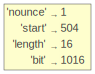

In [326]:
# создать указатель на найденное значение
def createPointerToValue(valueData):
    if (valueData["success"] == False):
        raise Exception("Pointer cannot be created: value not found")
    return {
        "nounce": valueData["nounce"],
        "start":  valueData["start"],
        "length": valueData["length"],
        "bit":    valueData["meta"]["absoluteStart"],
    }

testValueInHashes = findValueInHashes(Bits('0x39fa'), 1, 2**16)
testCreatePointerToValue = createPointerToValue(testValueInHashes)
display(objviz(testCreatePointerToValue))

In [210]:
def readBitPosition(bitPosition, length):
    """
    Read bits from hash space
    """
    cursor = parseBitPosition(bitPosition)
    return readValueFromBlock(cursor["nounce"], cursor["blockBit"], length)

testBitPositionValue = Bits('0xde')
testAbsoluteBitPosition = findValueInHashes(testBitPositionValue, 0, 512)["meta"]["absoluteStart"]
testCursorPosition  = parseBitPosition(testAbsoluteBitPosition)
testReadBitPosition = readBitPosition(70, 8)

print('Value:', testBitPositionValue)
print('Cursor position:', testCursorPosition)
print('Bit position:', testAbsoluteBitPosition)
print('result:', testReadBitPosition)

def readBytePosition(bytePosition):
    """
    Read one byte from hash space
    """
    cursor = parseBytePosition(bytePosition)
    return readValueFromBlock(cursor["nounce"], cursor["blockBit"], 8)

testBytePositionValue = Bits('0xde')
testCursorPosition    = createPointerToValue(findValueInHashes(testBytePositionValue, 0, 512))
testReadBytePosition  = readBitPosition(42, 8)

print('Value:', testBytePositionValue)
print('Cursor position:', testCursorPosition)
print('Byte position:', testReadBytePosition)

  0%|          | 0/512 [00:00<?, ?it/s]Value: 0xde
Cursor position: {'bit': 70, 'byte': 8, 'start': 70, 'blockBit': 70, 'blockByte': 8, 'nounce': 0}
Bit position: 70
result: 0xde
Value: 0xde
Cursor position: {'nounce': 0, 'start': 70, 'length': 8}
Byte position: 0x07



In [211]:
def parseBitPosition(bitPosition):
    """
    Get hash block nounce, and byte-aligned position from absolute bit position
    """
    bytePosition = bitPosition // 8
    nounce       = bitPosition // 512
    blockBit     = bitPosition % 512
    blockByte    = blockBit // 8
    return {
        "bit": bitPosition,
        "byte": bytePosition,
        "start": blockBit,
        "blockBit": blockBit,
        "blockByte": blockByte,
        "nounce": nounce
    }

def parseBytePosition(bytePosition):
    """
    Get hash block nounce, and byte-aligned position from absolute byte position
    """
    bitPosition = bytePosition * 8
    return parseBitPosition(bitPosition)

testParseBitPosition1 = parseBitPosition(535)
print(testParseBitPosition1)
testParseBitPosition1 = parseBitPosition(5002481)
print(testParseBitPosition1)
testParseBytePosition = parseBytePosition(66)
print(testParseBytePosition)

{'bit': 535, 'byte': 66, 'start': 23, 'blockBit': 23, 'blockByte': 2, 'nounce': 1}
{'bit': 5002481, 'byte': 625310, 'start': 241, 'blockBit': 241, 'blockByte': 30, 'nounce': 9770}
{'bit': 528, 'byte': 66, 'start': 16, 'blockBit': 16, 'blockByte': 2, 'nounce': 1}


In [324]:
def findByteLocations(dataBytes):
    # distance to previous value in bytes
    prevAddress = None
    nextAddress = None
    prevPointer = None
    nextPointer = None
    # last located value
    prevValue   = None
    nextValue   = None
    # start hash block number (nounce)
    fromNounce  = 0
    # max distance to next value (in bytes)
    maxByteDistance = 2 ** 16
    # max distance in 512-bit hash blocks
    maxBlockDistance = ((maxByteDistance * 8) // 512)
    # last saved value position
    prevLocation = 0
    # all value locations in orer apperance
    locations = list()
    for currentByte in dataBytes:
        # prepare byte for search
        currentBits = Bits(uint=currentByte, length=8)
        # searching from left to right, one direction
        if (prevLocation):
            # TODO disable "+1" shift
            fromNounce = prevLocation["nounce"] + 1
        # calculate available search range
        toNounce = fromNounce + maxBlockDistance
        # searching byte location
        location = findValueInHashes(currentBits, fromNounce, toNounce, bytealigned=True)
        # print('Location:', location)
        location["address"]     = parseBitPosition(location["meta"]["absoluteStart"])
        location["prevAddress"] = None
        location["nextAddress"] = None
        # value not found
        if (location["success"] == False):
            raise ValueError("byte value not found after 128 blocks")
        # send last location to result array
        if (prevLocation):
            # calculate relative distance between values
            relativeDistance = (location["address"]["byte"] - prevLocation["address"]["byte"])
            # save distance to result
            location["prevAddress"]      = relativeDistance
            # address = prev position - current position
            prevLocation["nextAddress"]  = relativeDistance
            # prevLocation["nextLocation"] = location
        # save results
        locations.append(location)
        # save last value location tbefore going to next byte
        prevLocation = location
    return locations

testFindByteLocations = findByteLocations(Bits('0xdeadbeef00aabbccddeeff').tobytes())
positionPointers      = list()
for i in range(0, len(testFindByteLocations)):
    currentPosition = parseBitPosition(testFindByteLocations[i]["meta"]["absoluteStart"])["byte"]
    if (i == 0):
        prevPosition = 0
        prevDistance = 0
    else:
        prevPosition = parseBitPosition(testFindByteLocations[i-1]["meta"]["absoluteStart"])["byte"]
        prevDistance = currentPosition - prevPosition
    if (i == len(testFindByteLocations)-1):
        nextPosition = 0
        nextDistance = 0
    else:
        nextPosition = parseBitPosition(testFindByteLocations[i+1]["meta"]["absoluteStart"])["byte"]
        nextDistance = nextPosition - currentPosition
    bytePointer = createPointerToValue(testFindByteLocations[i])
    byteValue   = readValueFromBlock(bytePointer["nounce"], bytePointer["start"], bytePointer["length"])
    positionPointer = prevPosition + nextPosition
    distancePointer = prevDistance + nextDistance
    print("")
    print(i, ':', bytePointer, '->', byteValue, '=', byteValue.uint)
    print(i, ':', parseBitPosition(testFindByteLocations[i]["meta"]["absoluteStart"]))
    print(i, ':', prevPosition, '<-', positionPointer, '->', nextPosition)
    print(i, ':', nextPosition, '=', positionPointer,  '-', prevPosition, '=', positionPointer - prevPosition)
    print(i, ':', prevDistance, '<-', distancePointer, '->', nextDistance)
    

  0%|          | 0/1024 [00:00<?, ?it/s]
0 : {'nounce': 0, 'start': 336, 'length': 8} -> 0xde = 222
0 : {'bit': 336, 'byte': 42, 'start': 336, 'blockBit': 336, 'blockByte': 42, 'nounce': 0}
0 : 0 <- 295 -> 295
0 : 295 = 295 - 0 = 295
0 : 0 <- 253 -> 253

1 : {'nounce': 4, 'start': 312, 'length': 8} -> 0xad = 173
1 : {'bit': 2360, 'byte': 295, 'start': 312, 'blockBit': 312, 'blockByte': 39, 'nounce': 4}
1 : 42 <- 439 -> 397
1 : 397 = 439 - 42 = 397
1 : 253 <- 355 -> 102

2 : {'nounce': 6, 'start': 104, 'length': 8} -> 0xbe = 190
2 : {'bit': 3176, 'byte': 397, 'start': 104, 'blockBit': 104, 'blockByte': 13, 'nounce': 6}
2 : 295 <- 883 -> 588
2 : 588 = 883 - 295 = 588
2 : 102 <- 293 -> 191

3 : {'nounce': 9, 'start': 96, 'length': 8} -> 0xef = 239
3 : {'bit': 4704, 'byte': 588, 'start': 96, 'blockBit': 96, 'blockByte': 12, 'nounce': 9}
3 : 397 <- 1119 -> 722
3 : 722 = 1119 - 397 = 722
3 : 191 <- 325 -> 134

4 : {'nounce': 11, 'start': 144, 'length': 8} -> 0x00 = 0
4 : {'bit': 5776, 'byte'

In [13]:
# search all natural numbers in hashes - good way to find all possible bit combitations
numberLocations = list()
# hashes diapason
fromNounce = 0
toNounce   = 2**28
# numbers
fromNumber = 2**24 - 20
toNumber   = 2**24 - 10
print('Searching values from ', fromNumber, 'to', toNumber)
for currentNumber in range(fromNumber, toNumber):
    minBits = bitLen(currentNumber)
    # minimally encoded integer value
    bitValue = Bits(uint=currentNumber, length=minBits)
    numberLocation    = findValueInHashes(bitValue, fromNounce, toNounce)
    bitPosition       = numberLocation["meta"]["absoluteStart"]
    parsedBitPosition = parseBitPosition(bitPosition)
    locationObject    = parsedBitPosition
    locationObject["success"]         = numberLocation["success"]
    locationObject["blocksProcessed"] = numberLocation["meta"]["blocksProcessed"]
    # update nounce
    # fromNounce = pasrseBitPosition(numberLocation)["nounce"]
    # toNounce   = toNounce + fromNounce
    print("")
    print(currentNumber, ':', 'bits:', minBits, 'value:', bitValue)
    # print('location:', numberLocation)
    print('location object:', locationObject)
    # display(objviz(locationObject))

  0%|          | 566/268435456 [00:00<13:11:37, 5651.57it/s]
16777196 : bits: 24 value: 0xffffec
location object: {'bit': 6368334, 'byte': 796041, 'start': 78, 'blockBit': 78, 'blockByte': 9, 'nounce': 12438, 'success': True, 'blocksProcessed': 12439}
  0%|          | 588/268435456 [00:00<12:54:09, 5779.12it/s]
16777197 : bits: 24 value: 0xffffed
location object: {'bit': 5015973, 'byte': 626996, 'start': 421, 'blockBit': 421, 'blockByte': 52, 'nounce': 9796, 'success': True, 'blocksProcessed': 9797}
  0%|          | 317/268435456 [00:00<23:33:22, 3165.43it/s]
16777198 : bits: 24 value: 0xffffee
location object: {'bit': 15514983, 'byte': 1939372, 'start': 359, 'blockBit': 359, 'blockByte': 44, 'nounce': 30302, 'success': True, 'blocksProcessed': 30303}
  0%|          | 358/268435456 [00:00<20:52:20, 3572.46it/s]
16777199 : bits: 24 value: 0xffffef
location object: {'bit': 2103527, 'byte': 262940, 'start': 231, 'blockBit': 231, 'blockByte': 28, 'nounce': 4108, 'success': True, 'blocksPro

In [14]:
data      = Bits('0xaabbccddeeffaabbccddeeff')
dataBytes = list()
print(len(data), len(data) // 8)
for i in range(0, 12):
    start    = i * 8
    end      = start + 8
    dataByte = data[start:end]
    byteInt  = dataByte.uint
    rawByte  = dataByte.tobytes()
    dataBytes.append(dataByte)
    print(i, ':', 'byte:', dataByte.bin, 'int:', byteInt, 'raw:', rawByte)


96 12
0 : byte: 10101010 int: 170 raw: b'\xaa'
1 : byte: 10111011 int: 187 raw: b'\xbb'
2 : byte: 11001100 int: 204 raw: b'\xcc'
3 : byte: 11011101 int: 221 raw: b'\xdd'
4 : byte: 11101110 int: 238 raw: b'\xee'
5 : byte: 11111111 int: 255 raw: b'\xff'
6 : byte: 10101010 int: 170 raw: b'\xaa'
7 : byte: 10111011 int: 187 raw: b'\xbb'
8 : byte: 11001100 int: 204 raw: b'\xcc'
9 : byte: 11011101 int: 221 raw: b'\xdd'
10 : byte: 11101110 int: 238 raw: b'\xee'
11 : byte: 11111111 int: 255 raw: b'\xff'


In [213]:
def findByteBasedDistance(prevByte, prevDistance, nextByte):
    """
    Найти адрес по которому находится varint содержащий значение-множитель, 
    при умножении uint-значения prevByte на который мы получаем адрес nextByte 
    """
    prevByteInt = prevByte.uint
    nextByteInt = prevByte.uint
    prevValue   = prevByte + prevDistance
    print('targetValue:', prevValue.bin, len(prevValue))
    prevAddress     = findValueInHashes(prevValue, 0, 2**16)
    bitPosition     = prevAddress["meta"]["absoluteStart"]
    print('prevAddress:', prevAddress, 'prevPos:', bitPosition)
    prevAddressBits = Bits(uint=bitPosition, length=16)
    print(prevAddressBits.bin)
    return prevAddress
    # prevAddress = findValueInHashes(prevValue, 0, 2 ** 14 // 512)
    # nextValue
    #for distance in range(1, 2**14):
    #    bitPosition = distance * prevByteInt
    #    byte        = readBitPosition(bitPosition)
    #    print('d:', distance, 'bitpos:', bitPosition, 'posval:', byte.bin, 'next/tgtbyte:', nextByte.bin)
    #    if (byte == nextByte):
    #        print('distance found:', distance, 'position:', )
    #        
    #        break

testFindBasedDistance = findByteBasedDistance(Bits('0b11111111'), Bits('0b00000001'), Bits('0b11101110'))
print(testFindBasedDistance)
byteValue = readBitPosition(testFindBasedDistance["meta"]["absoluteStart"], 16)
print('Read from hashes:', byteValue.bin)

  0%|          | 87/65536 [00:00<00:16, 4045.91it/s]targetValue: 1111111100000001 16
prevAddress: {'success': True, 'nounce': 87, 'start': 351, 'end': 367, 'length': 16, 'meta': {'value': Bits('0xff01'), 'valueLength': 16, 'absoluteStart': 44895, 'absoluteEnd': 44911, 'offset': 44544, 'fromNounce': 0, 'toNounce': 65536, 'blocksProcessed': 88, 'allPositions': [351], 'valuesFound': 1}} prevPos: 44895
1010111101011111
{'success': True, 'nounce': 87, 'start': 351, 'end': 367, 'length': 16, 'meta': {'value': Bits('0xff01'), 'valueLength': 16, 'absoluteStart': 44895, 'absoluteEnd': 44911, 'offset': 44544, 'fromNounce': 0, 'toNounce': 65536, 'blocksProcessed': 88, 'allPositions': [351], 'valuesFound': 1}}
Read from hashes: 1111111100000001



In [16]:

locations        = findByteLocations(data.tobytes())
locationPointers = list()
prevBit = 0
print("")
for i in range(0, len(locations)):
    bytePointer             = createPointerToValue(locations[i])
    byteValue               = readValueFromBlock(bytePointer["nounce"], bytePointer["start"], bytePointer["length"])
    bytePointer["bit"]      = locations[i]["meta"]["absoluteStart"]
    bytePointer["distance"] = bytePointer["bit"] - prevBit
    bytePointer["value"]    = byteValue
    locationPointers.append(bytePointer)
    print(i, ':', bytePointer, '->', byteValue, '[', byteValue.uint, ']')
    prevBit = bytePointer["bit"]

NameError: name 'data' is not defined

In [134]:
prevPosition = 0
prevDistance = 0
tailValue    = locationPointers[11]["value"]
print(11, ':', locationPointers[11], '->', locationPointers[11]["value"], '[', locationPointers[11]["value"].uint, ']')

for lpNum in range(1, len(locationPointers)):
    i = 11 - lpNum
    tailValue = locationPointers[i]["value"]
    headValue = locationPointers[i+1]["value"]
    headBit   = locationPointers[i+1]["bit"]
    prevDistanceEncoded = Bits(bytes=varint.encode(prevDistance))
    prevValue           = prevDistanceEncoded + tailValue
    print("")
    print(i, ':', locationPointers[i])
    print(i, ':', 'head:', headValue, '[', headValue.uint, ']')
    print(i, ':', 'tail:', tailValue, '[', tailValue.uint, ']')
    print(i, ':', 'value:', prevValue.bin, '(', len(prevValue), ')')
    for distance in tqdm(range(prevPosition, (prevPosition + 2**21))):
        scanPosition        = prevPosition + headValue.uint * distance
        scanValue           = readBitPosition(scanPosition, len(prevValue))
        if (scanValue == prevValue):
            print("")
            print(i, ':', 'prev_val:', prevValue.bin)
            print(i, ':', 'prev_pos:', prevPosition)
            print(i, ':', ' prev_x:', prevDistance)
            print(i, ':', 'x =', distance)
            print(i, ':', 'tailBit:', scanPosition)
            print(i, ':', '    x * head =', scanPosition)
            print(i, ':', distance, '* ', tailValue.uint, '+', prevPosition, '=', (distance * tailValue.uint) + prevPosition)
            print(i, ':', 'readBitPosition(', (distance * tailValue.uint) + prevPosition, '):', readBitPosition(scanPosition, len(prevValue)).bin)
            prevPosition = scanPosition
            prevDistance = distance
            break
        if (distance == (2**21 - 1)):
            print(i, ':', 'distance bits expired')

  0%|          | 828/2097152 [00:00<04:13, 8275.15it/s]11 : {'nounce': 34, 'start': 96, 'length': 8, 'bit': 17504, 'distance': 544, 'value': Bits('0xff')} -> 0xff [ 255 ]

10 : {'nounce': 33, 'start': 64, 'length': 8, 'bit': 16960, 'distance': 1032, 'value': Bits('0xee')}
10 : head: 0xff [ 255 ]
10 : tail: 0xee [ 238 ]
10 : value: 0000000011101110 ( 16 )
  0%|          | 1034/2097152 [00:00<03:22, 10335.20it/s]
10 : prev_val: 0000000011101110
10 : prev_pos: 0
10 :  prev_x: 0
10 : x = 18943
10 : tailBit: 4830465
10 :     x * head = 4830465
10 : 18943 *  238 + 0 = 4508434
10 : readBitPosition( 4508434 ): 0000000011101110

9 : {'nounce': 31, 'start': 56, 'length': 8, 'bit': 15928, 'distance': 768, 'value': Bits('0xdd')}
9 : head: 0xee [ 238 ]
9 : tail: 0xdd [ 221 ]
9 : value: 11111111100100110000000111011101 ( 32 )
 35%|███▌      | 743847/2097152 [03:39<06:39, 3383.80it/s]


KeyboardInterrupt: 

In [84]:
print("")
b10 = {
    "currentValue"     : locationPointers[10]['value'],
    "nextValuePosition": 0
}
b10PositionEncoded = varint.encode(b10["nextValuePosition"])
b10Encoded         = b10["currentValue"] + Bits(bytes=b10PositionEncoded)
print('Starting search:', b10Encoded.bin, 'length:', len(b10Encoded))
b10Address         = findValueInHashes(b10Encoded, 0, 2**24)
b10Position        = b10Address["meta"]["absoluteStart"]
print("")
print('b10Encoded:', b10Encoded, 'position:', b10Position)
print('b10PositionEncoded:', b10PositionEncoded, len(b10PositionEncoded))
print('b10Address:', b10Address)


print("")
b09 = {
    "currentValue"     : locationPointers[9]['value'],
    "nextValuePosition": b10Position
}
b09PositionEncoded = varint.encode(b09["nextValuePosition"])
b09Encoded         = b09["currentValue"] + Bits(bytes=b09PositionEncoded)
print('Starting search:', b09Encoded.bin, 'length:', len(b09Encoded))
b09Address         = findValueInHashes(b09Encoded, 0, 2**24)
b09Position        = b09Address["meta"]["absoluteStart"]
print("")
print('b09Encoded:', b09Encoded, 'position:', b09Position)
print('b09PositionEncoded:', b09PositionEncoded, len(b09PositionEncoded))
print('b09Address:', b09Address)


print("")
b08 = {
    "currentValue"     : locationPointers[8]['value'],
    "nextValuePosition": b09Position
}
b08PositionEncoded = varint.encode(b08["nextValuePosition"])
b08Encoded         = b08["currentValue"] + Bits(bytes=b08PositionEncoded)
print('Starting search:', b08Encoded.bin, 'length:', len(b08Encoded))
b08Address         = findValueInHashes(b08Encoded, 0, 2**24)
b08Position        = b08Address["meta"]["absoluteStart"]
print("")
print('b08Encoded:', b08Encoded, 'position:', b08Position)
print('b08PositionEncoded:', b08PositionEncoded, len(b08PositionEncoded))
print('b08Address:', b08Address)

  0%|          | 331/16777216 [00:00<1:24:30, 3308.43it/s]
b10Encoded: 0xff00 address: {'success': True, 'nounce': 184, 'start': 65, 'end': 81, 'length': 16, 'meta': {'value': Bits('0xff00'), 'valueLength': 16, 'absoluteStart': 94273, 'absoluteEnd': 94289, 'offset': 94208, 'fromNounce': 0, 'toNounce': 16777216, 'blocksProcessed': 185, 'allPositions': [65], 'valuesFound': 1}}
position: 94273
b10PositionEncoded: b'\x00' 1
  0%|          | 177/16777216 [00:00<2:38:50, 1760.33it/s]
b09Encoded: 0xeec1e005 address: {'success': True, 'nounce': 2524430, 'start': 170, 'end': 202, 'length': 32, 'meta': {'value': Bits('0xeec1e005'), 'valueLength': 32, 'absoluteStart': 1292508330, 'absoluteEnd': 1292508362, 'offset': 1292508160, 'fromNounce': 0, 'toNounce': 16777216, 'blocksProcessed': 2524431, 'allPositions': [170], 'valuesFound': 1}} position: 1292508330
b09PositionEncoded: b'\xc1\xe0\x05' 3
100%|██████████| 16777216/16777216 [1:26:04<00:00, 3248.46it/s]


KeyError: 'absoluteStart'

In [83]:
b08Data          = Bits('0x0')
b08Value         = b08Data[0:8]
b08Position      = varint.decode_bytes(b08Data[8:].bytes)
b08PositionValue = readBitPosition(b08Position, len(b08Data))
print('b08Value:', b08Value, 'b08Data:', b08Data.bin, 'b08Position:', b08Position, '->', b08PositionValue)

b09Data          = b08PositionValue # Bits('0xeec1e005')
b09Value         = b09Data[0:8]
b09Position      = varint.decode_bytes(b09Data[8:].bytes)
b09PositionValue = readBitPosition(b09Position, len(b09Data))
print('b09Value:', b09Value, 'b09Data:', b09Data.bin, 'b09Position:', b09Position, '->', b09PositionValue)

b10Data          = b09PositionValue
b10Value         = b10Data[0:8]
b10Position      = varint.decode_bytes(b10Data[8:].bytes)
b10PositionValue = readBitPosition(b10Position, len(b10Data))
print('b10Value:', b10Value, 'b10Data:', b10Data.bin, 'b10Position:', b10Position, '->', b10PositionValue)

b09Value: 0xee b09Data: 11101110110000011110000000000101 b09Position: 94273 -> 0xff009a56
b10Value: 0xff b10Data: 11111111000000001001101001010110 b10Position: 0 -> 0xb8244d02


In [ ]:
l10 = {
    'value':    locationPointers[11]['value'],
    'distance': 0,
}
l10Encoded = l10["value"] + Bits(bytes=varint.encode(b09["distance"]))
print('l10Encoded:', l10Encoded)



In [118]:
data      = Bits('0xabcdef')
dataBytes = list()
partSize  = 2
totalParts = len(data) // partSize
print(len(data), '/', partSize, '=', totalParts)
for i in range(0, totalParts):
    start    = i * partSize
    end      = start + partSize
    dataByte = data[start:end]
    byteInt  = dataByte.uint
    rawByte  = dataByte.tobytes()
    dataBytes.append(dataByte)
    print(i, ':', 'bin:', dataByte.bin, 'int:', byteInt, 'hex:', dataByte.bin)


24 / 2 = 12
0 : bin: 10 int: 2 hex: 10
1 : bin: 10 int: 2 hex: 10
2 : bin: 10 int: 2 hex: 10
3 : bin: 11 int: 3 hex: 11
4 : bin: 11 int: 3 hex: 11
5 : bin: 00 int: 0 hex: 00
6 : bin: 11 int: 3 hex: 11
7 : bin: 01 int: 1 hex: 01
8 : bin: 11 int: 3 hex: 11
9 : bin: 10 int: 2 hex: 10
10 : bin: 11 int: 3 hex: 11
11 : bin: 11 int: 3 hex: 11


In [309]:
listPositions = list()
# addressLength  = 16
valueLength    = 13
distanceLength = 10
dataLength     = 2
prevPosition   = 0
scanPosition   = 0

def findNextByte(prevPosition, dataByte):
    prevValue = readBitPosition(prevPosition, valueLength)
    for distance in range(0, 2**distanceLength):
        scanPosition = prevPosition + distance
        scanValue    = readBitPosition(scanPosition, valueLength)
        # encodedDistance = Bits(bytes=varint.encode(distance))
        # decodedValue    = varint.decode_bytes(scanValue[5:13].tobytes())
        if (not(scanValue[0]) and (scanValue[1:3].uint == dataByte.uint)):
            return {
                "success"      : True,
                "prevPosition" : prevPosition,
                "position"     : scanPosition,
                "distance"     : scanValue[3:valueLength].uint,
                "value"        : scanValue,
                # "encodedDistance": encodedDistance.
                "bin"          : scanValue[1:3].bin
            }
    # data value not found - search for placeholder
    maxSkipDistance = 0
    maxSkipPosition = 0
    maxSkipValue    = None
    distance        = 0
    for distance in range(0, 2**distanceLength):
        scanPosition    = prevPosition + distance
        scanValue       = readBitPosition(scanPosition, valueLength)
        distanceSize    = bitLen(distance)
        distanceBits    = Bits(uint=distanceSize, length=4)
        tailValue       = scanValue[valueLength-3:valueLength].uint
        tailLength      = len(scanValue[valueLength-3:valueLength])

        nextPosition = scanPosition + scanValue[3:valueLength].uint
        nextValue    = readBitPosition(nextPosition, valueLength)
        
        if (scanValue[0] and nextValue[0]):
            return {
                "success"       : False,
                "prevPosition"  : prevPosition,
                "position"      : scanPosition,
                "scanDistance"  : distance,
                "distance"      : scanValue[3:valueLength].uint,
                # "encodedDistance": encodedDistance.
                "value"         : scanValue,
                "bin"           : scanValue[1:3],
                #"distanceBits"  : distanceBits.bin,
                #"tailLength"    : tailLength,
                #"tailValue"     : tailValue
            }
    # no pointer chain for this interval
    raise Exception('Value not found')
            

for i in range(0, len(dataBytes)):
    dataByte = dataBytes[i]
    dataInt  = dataByte.uint
    for d in tqdm(range(0, 2**24)):
        scanResult = findNextByte(prevPosition, dataByte)
        listPositions.append(scanResult)
        if scanResult["success"]:
            print("")
            print(i, '/', len(listPositions), ':', scanResult["value"][0], '[MATCH]', scanResult, '(', scanResult["position"], ')', scanResult["bin"], '=>', dataByte.bin, 'posValue:', readBitPosition(scanResult["position"], 13))
            prevPosition = prevPosition + scanResult["distance"]
            break
        else:
            print("")
            print(i, '/', len(listPositions), ':', scanResult["value"][0], '[skip]', scanResult, '(', scanResult["position"], ')')
            prevPosition = prevPosition + scanResult["distance"]

len(listPositions)

  0%|          | 0/16777216 [00:00<?, ?it/s]
0 / 1 : False [MATCH] {'success': True, 'prevPosition': 0, 'position': 9, 'distance': 275, 'value': Bits('0b0100100010011'), 'bin': '10'} ( 9 ) 10 => 10 posValue: 0b0100100010011

1 / 2 : False [MATCH] {'success': True, 'prevPosition': 275, 'position': 281, 'distance': 668, 'value': Bits('0b0101010011100'), 'bin': '10'} ( 281 ) 10 => 10 posValue: 0b0101010011100

2 / 3 : False [MATCH] {'success': True, 'prevPosition': 943, 'position': 959, 'distance': 673, 'value': Bits('0b0101010100001'), 'bin': '10'} ( 959 ) 10 => 10 posValue: 0b0101010100001

3 / 4 : False [MATCH] {'success': True, 'prevPosition': 1616, 'position': 1624, 'distance': 526, 'value': Bits('0b0111000001110'), 'bin': '11'} ( 1624 ) 11 => 11 posValue: 0b0111000001110

4 / 5 : False [MATCH] {'success': True, 'prevPosition': 2142, 'position': 2142, 'distance': 183, 'value': Bits('0b0110010110111'), 'bin': '11'} ( 2142 ) 11 => 11 posValue: 0b0110010110111

5 / 6 : False [MATCH] {'s

12

In [310]:
testPrevPosition = listPositions[0]["position"]
prevValue        = None
for i in range(1, len(listPositions)):
    listItem     = listPositions[i]
    
    prevValue    = readBitPosition(testPrevPosition, 13)
    prevDistance = prevValue[3:13].uint
    
    itemPosition = listItem["position"]
    testPosition = testPrevPosition + testValue[3:13].uint

    itemValue    = listItem["value"]
    testValue    = readBitPosition(listItem["position"], 13)

    itemDistance = listItem["distance"]
    testDistance = testValue[3:13].uint
    
    listSuccess = listItem["success"]
    testSuccess = testValue[0]
    
    testItem     = {
        "success"      : testSuccess,
        "prevPosition" : testPrevPosition,
        "position"     : testPosition,
        "distance"     : testDistance,
        "value"        : testValue
    }

    print(i, ':', 'listItem:', listItem)
    print(i, ':', 'testItem:', testItem)
    print("")

    testPrevPosition = testPosition

1 : listItem: {'success': True, 'prevPosition': 275, 'position': 281, 'distance': 668, 'value': Bits('0b0101010011100'), 'bin': '10'}
1 : testItem: {'success': False, 'prevPosition': 9, 'position': 196, 'distance': 668, 'value': Bits('0b0101010011100')}

2 : listItem: {'success': True, 'prevPosition': 943, 'position': 959, 'distance': 673, 'value': Bits('0b0101010100001'), 'bin': '10'}
2 : testItem: {'success': False, 'prevPosition': 196, 'position': 864, 'distance': 673, 'value': Bits('0b0101010100001')}

3 : listItem: {'success': True, 'prevPosition': 1616, 'position': 1624, 'distance': 526, 'value': Bits('0b0111000001110'), 'bin': '11'}
3 : testItem: {'success': False, 'prevPosition': 864, 'position': 1537, 'distance': 526, 'value': Bits('0b0111000001110')}

4 : listItem: {'success': True, 'prevPosition': 2142, 'position': 2142, 'distance': 183, 'value': Bits('0b0110010110111'), 'bin': '11'}
4 : testItem: {'success': False, 'prevPosition': 1537, 'position': 2063, 'distance': 183, 'v

In [151]:
print(listPositions[0])
print(listPositions[1])
print(listPositions[2])
print(listPositions[3])
print(listPositions[4])
print(listPositions[5])
print(listPositions[6])
print("...")
print(listPositions[len(listPositions)-9])
print(listPositions[len(listPositions)-8])
print(listPositions[len(listPositions)-7])
print(listPositions[len(listPositions)-6])
print(listPositions[len(listPositions)-5])
print(listPositions[len(listPositions)-4])
print(listPositions[len(listPositions)-3])
print(listPositions[len(listPositions)-2])
print(listPositions[len(listPositions)-1])

{'success': False, 'prevPosition': 0, 'position': 2, 'distance': 1024, 'value': Bits('0b1110000010010'), 'hex': '11'}
{'success': False, 'prevPosition': 1024, 'position': 1025, 'distance': 1024, 'value': Bits('0b1111010101110'), 'hex': '11'}
{'success': False, 'prevPosition': 2048, 'position': 2050, 'distance': 1024, 'value': Bits('0b1101011011100'), 'hex': '10'}
{'success': False, 'prevPosition': 3072, 'position': 3073, 'distance': 1024, 'value': Bits('0b1011000000101'), 'hex': '01'}
{'success': True, 'prevPosition': 4096, 'position': 5079, 'distance': 983, 'value': Bits('0b0101111010111'), 'hex': '10'}
{'success': False, 'prevPosition': 5079, 'position': 5080, 'distance': 1024, 'value': Bits('0b1011110101111'), 'hex': '01'}
{'success': False, 'prevPosition': 6103, 'position': 6106, 'distance': 1024, 'value': Bits('0b1111101110110'), 'hex': '11'}
...
{'success': False, 'prevPosition': 117466, 'position': 117468, 'distance': 1024, 'value': Bits('0b1100101110100'), 'hex': '10'}
{'succes

In [148]:
prevPosition = listPositions[len(listPositions)-1]["position"]
prevValue    = readBitPosition(prevPosition, 13) # listPositions[len(listPositions)-1]["value"]
if (prevValue[0]):
    prevDistance = 255
else:
    prevDistance = prevValue[5:13].uint # listPositions[len(listPositions)-1]["value"][5:13].uint

currentPosition = prevPosition - prevDistance 
currentValue    = readBitPosition(currentPosition, 13)
if (currentValue[0]):
    currentDistance = 255
else:
    currentDistance = currentValue[5:13].uint

nextPosition = currentPosition - currentDistance
nextValue    = readBitPosition(nextPosition, 13)
if (nextValue[0]):
    nextDistance = 255
else:
    nextDistance = nextValue[5:13].uint

print(len(listPositions)-1, ':', prevPosition, prevValue, prevValue[1:5].hex, prevDistance, '->', listPositions[len(listPositions)-1]["bin"])
print(len(listPositions)-2, ':', currentPosition, currentValue, currentValue[1:5].hex, currentDistance, '->', listPositions[len(listPositions)-2]["bin"])
print(len(listPositions)-3, ':', nextPosition, nextValue, nextValue[1:5].hex, nextDistance, '->', listPositions[len(listPositions)-3]["bin"])

128 : 125989 0b0110101001011 d 75 -> 11
127 : 125914 0b0101101110001 b 113 -> 10
126 : 125801 0b1100100110110 9 255 -> 10


In [150]:
prevPosition = listPositions[len(listPositions)-1]["position"]
prevValue    = readBitPosition(prevPosition, 13)
prevData     = prevValue[1:3].bin
# prevData     = prevValue[1:5].hex
if (prevValue[0]):
    prevDistance = 2**10
else:
    prevDistance = prevValue[3:13].uint

for i in range(0, len(listPositions)):
    prevValue    = readBitPosition(prevPosition, 13)
    # prevData     = prevValue[1:5].hex
    #if (prevValue[0]):
    #    prevDistance = 255
    #else:
    #    prevDistance = prevValue[5:13].uint
    print(len(listPositions) - i, ':', prevPosition, '<->', listPositions[len(listPositions)-1-i]["position"], '|',prevDistance, prevValue, '->', prevData, 'skip:', prevValue[0], (prevPosition + prevDistance))
    currentPosition = prevPosition - prevDistance
    currentValue    = readBitPosition(currentPosition, 13)
    currentData     = currentValue[1:3].bin
    if (currentValue[0]):
        currentDistance = 2**10
    else:
        currentDistance = currentValue[3:13].uint
        # print("[MATCH]")
    # print(len(listPositions) - i, ':', currentPosition, '<->', listPositions[len(listPositions)-2-i]["position"], '|', currentDistance, currentValue, '->', currentData, 'skp:', currentValue[0])
    print("")
    prevPosition = currentPosition
    prevDistance = currentDistance
    prevValue    = currentValue
    prevData     = currentData
    # 
    #print("")

129 : 125989 <-> 125989 | 331 0b0110101001011 -> 11 skp: False 126320

128 : 125658 <-> 124635 | 278 0b0100100010110 -> 10 skp: False 125936

127 : 125380 <-> 123611 | 1024 0b1000110110011 -> 00 skp: True 126404

126 : 124356 <-> 122588 | 1024 0b1000101010111 -> 00 skp: True 125380

125 : 123332 <-> 121564 | 1024 0b1101101110010 -> 10 skp: True 124356

124 : 122308 <-> 120539 | 1024 0b1111000111111 -> 11 skp: True 123332

123 : 121284 <-> 119515 | 150 0b0100010010110 -> 10 skp: False 121434

122 : 121134 <-> 118493 | 1024 0b1011100011011 -> 01 skp: True 122158

121 : 120110 <-> 117468 | 1024 0b1010000111111 -> 01 skp: True 121134

120 : 119086 <-> 116443 | 30 0b0000000011110 -> 00 skp: False 119116

119 : 119056 <-> 116442 | 1024 0b1111010000000 -> 11 skp: True 120080

118 : 118032 <-> 115198 | 553 0b0011000101001 -> 01 skp: False 118585

117 : 117479 <-> 114174 | 33 0b0000000100001 -> 00 skp: False 117512

116 : 117446 <-> 113155 | 655 0b0001010001111 -> 00 skp: False 118101

115 : 11

In [215]:
def findValueBytes(bitFrom):
    valueBytes = list()
    for distance in range(0, 2**8):
        position  = bitFrom + distance
        valueByte = readBitPosition(position, 10)[2:10]
        valueBytes.append(valueByte)
    return valueBytes

testFindValueBytes = findValueBytes(0)
for i in range(0, 2**8):
    byteValue = testFindValueBytes[i]
    paddingLength = 3 - len(str(i))
    padding = (' ' * paddingLength) + ':'
    print(i, padding, byteValue, '=', byteValue.bin, '=', byteValue.uint)

0   : 0xe0 = 11100000 = 224
1   : 0xc1 = 11000001 = 193
2   : 0x82 = 10000010 = 130
3   : 0x04 = 00000100 = 4
4   : 0x09 = 00001001 = 9
5   : 0x12 = 00010010 = 18
6   : 0x24 = 00100100 = 36
7   : 0x48 = 01001000 = 72
8   : 0x91 = 10010001 = 145
9   : 0x22 = 00100010 = 34
10  : 0x44 = 01000100 = 68
11  : 0x89 = 10001001 = 137
12  : 0x13 = 00010011 = 19
13  : 0x26 = 00100110 = 38
14  : 0x4d = 01001101 = 77
15  : 0x9a = 10011010 = 154
16  : 0x34 = 00110100 = 52
17  : 0x68 = 01101000 = 104
18  : 0xd0 = 11010000 = 208
19  : 0xa0 = 10100000 = 160
20  : 0x40 = 01000000 = 64
21  : 0x81 = 10000001 = 129
22  : 0x02 = 00000010 = 2
23  : 0x05 = 00000101 = 5
24  : 0x0a = 00001010 = 10
25  : 0x14 = 00010100 = 20
26  : 0x28 = 00101000 = 40
27  : 0x51 = 01010001 = 81
28  : 0xa2 = 10100010 = 162
29  : 0x44 = 01000100 = 68
30  : 0x89 = 10001001 = 137
31  : 0x13 = 00010011 = 19
32  : 0x26 = 00100110 = 38
33  : 0x4c = 01001100 = 76
34  : 0x98 = 10011000 = 152
35  : 0x30 = 00110000 = 48
36  : 0x60 = 011000

In [216]:
def findValuePrefixes(bitFrom, targetValue=None):
    if ((targetValue != None) and (isinstance(targetValue, int))):
        targetValue = Bits(uint=targetValue, length=2)
    valuePrefixes = list()
    for distance in range(0, 2**8):
        position = bitFrom + distance
        value    = readBitPosition(position, 10)
        prefix   = value[0:2]
        valuePrefix = {
            "prefix"   : prefix,
            "value"    : value,
            "position" : position,
            "distance" : distance,
            "byteValue" : value[2:10].uint,
        }
        if ((targetValue == None) or (targetValue.uint == prefix.uint)):
            valuePrefixes.append(valuePrefix)
    return valuePrefixes

testFindValuePrefixes = findValuePrefixes(0, Bits('0b00'))
for i in range(0, len(testFindValuePrefixes)):
    prefixValue   = testFindValuePrefixes[i]
    paddingLength = 3 - len(str(i))
    padding = (' ' * paddingLength) + ':'
    print(i, padding, prefixValue, prefixValue["value"].uint)
print("")
print('length:', len(testFindValuePrefixes))

0   : {'prefix': Bits('0b00'), 'value': Bits('0b0000010010'), 'position': 5, 'distance': 5, 'byteValue': 18} 18
1   : {'prefix': Bits('0b00'), 'value': Bits('0b0000100100'), 'position': 6, 'distance': 6, 'byteValue': 36} 36
2   : {'prefix': Bits('0b00'), 'value': Bits('0b0001001000'), 'position': 7, 'distance': 7, 'byteValue': 72} 72
3   : {'prefix': Bits('0b00'), 'value': Bits('0b0010010001'), 'position': 8, 'distance': 8, 'byteValue': 145} 145
4   : {'prefix': Bits('0b00'), 'value': Bits('0b0010001001'), 'position': 11, 'distance': 11, 'byteValue': 137} 137
5   : {'prefix': Bits('0b00'), 'value': Bits('0b0001001101'), 'position': 14, 'distance': 14, 'byteValue': 77} 77
6   : {'prefix': Bits('0b00'), 'value': Bits('0b0010011010'), 'position': 15, 'distance': 15, 'byteValue': 154} 154
7   : {'prefix': Bits('0b00'), 'value': Bits('0b0011010000'), 'position': 18, 'distance': 18, 'byteValue': 208} 208
8   : {'prefix': Bits('0b00'), 'value': Bits('0b0000001010'), 'position': 24, 'distance'

In [196]:
def findValueSuffixes(bitFrom, length, targetValue=None):
    if ((targetValue != None) and (isinstance(targetValue, int))):
        targetValue = Bits(uint=targetValue, length=length)
    valueSuffixes = list()
    for distance in range(0, 2**8):
        position    = bitFrom + distance
        value       = readBitPosition(position, 10)
        suffix      = value[10-length:10]
        valueSuffix = {
            "suffix"   : suffix,
            "value"    : value,
            "position" : position,
            "distance" : distance,
            "byteValue" : value[2:10].uint
        }
        if ((targetValue == None) or (targetValue.uint == suffix.uint)):
            valueSuffixes.append(valueSuffix)
    return valueSuffixes

testFindValueSuffixes3 = findValueSuffixes(0, 3, Bits('0b010'))
for i in range(0, len(testFindValueSuffixes3)):
    suffixValue   = testFindValueSuffixes3[i]
    paddingLength = 3 - len(str(i))
    padding = (' ' * paddingLength) + ':'
    print(i, padding, suffixValue, suffixValue["suffix"].uint)

0   : {'suffix': Bits('0b010'), 'value': Bits('0b1110000010'), 'position': 2, 'distance': 2, 'byteValue': 130} 2
1   : {'suffix': Bits('0b010'), 'value': Bits('0b0000010010'), 'position': 5, 'distance': 5, 'byteValue': 18} 2
2   : {'suffix': Bits('0b010'), 'value': Bits('0b0100100010'), 'position': 9, 'distance': 9, 'byteValue': 34} 2
3   : {'suffix': Bits('0b010'), 'value': Bits('0b0010011010'), 'position': 15, 'distance': 15, 'byteValue': 154} 2
4   : {'suffix': Bits('0b010'), 'value': Bits('0b0100000010'), 'position': 22, 'distance': 22, 'byteValue': 2} 2
5   : {'suffix': Bits('0b010'), 'value': Bits('0b0000001010'), 'position': 24, 'distance': 24, 'byteValue': 10} 2
6   : {'suffix': Bits('0b010'), 'value': Bits('0b0010100010'), 'position': 28, 'distance': 28, 'byteValue': 162} 2
7   : {'suffix': Bits('0b010'), 'value': Bits('0b0000111010'), 'position': 43, 'distance': 43, 'byteValue': 58} 2
8   : {'suffix': Bits('0b010'), 'value': Bits('0b1101011010'), 'position': 48, 'distance': 4

In [199]:
testFindValueSuffixes0 = findValueSuffixes(0, 0)
for i in range(0, len(testFindValueSuffixes0)):
    suffixValue   = testFindValueSuffixes0[i]
    paddingLength = 3 - len(str(i))
    padding = (' ' * paddingLength) + ':'
    if (suffixValue["byteValue"] == suffixValue["distance"]):
        print("\n[MATCH]")
    print(i, padding, suffixValue, 'length:', len(suffixValue["suffix"]))

0   : {'suffix': Bits(''), 'value': Bits('0b1011100000'), 'position': 0, 'distance': 0, 'byteValue': 224} length: 0
1   : {'suffix': Bits(''), 'value': Bits('0b0111000001'), 'position': 1, 'distance': 1, 'byteValue': 193} length: 0
2   : {'suffix': Bits(''), 'value': Bits('0b1110000010'), 'position': 2, 'distance': 2, 'byteValue': 130} length: 0
3   : {'suffix': Bits(''), 'value': Bits('0b1100000100'), 'position': 3, 'distance': 3, 'byteValue': 4} length: 0
4   : {'suffix': Bits(''), 'value': Bits('0b1000001001'), 'position': 4, 'distance': 4, 'byteValue': 9} length: 0
5   : {'suffix': Bits(''), 'value': Bits('0b0000010010'), 'position': 5, 'distance': 5, 'byteValue': 18} length: 0
6   : {'suffix': Bits(''), 'value': Bits('0b0000100100'), 'position': 6, 'distance': 6, 'byteValue': 36} length: 0
7   : {'suffix': Bits(''), 'value': Bits('0b0001001000'), 'position': 7, 'distance': 7, 'byteValue': 72} length: 0
8   : {'suffix': Bits(''), 'value': Bits('0b0010010001'), 'position': 8, 'dista

In [217]:
def findValueItems(bitFrom, targetPrefix, targetSuffix):
    if ((targetPrefix != None) and (isinstance(targetPrefix, int))):
        targetPrefix = Bits(uint=targetPrefix, length=2)
    suffixLength = targetPrefix.uint
    if ((targetSuffix != None) and (isinstance(targetSuffix, int))):
        targetSuffix = Bits(uint=targetSuffix, length=suffixLength)
    valueItems = list()
    for distance in range(0, 2**8):
        position = bitFrom + distance
        value    = readBitPosition(position, 10)
        prefix   = value[0:2]
        suffix   = value[10-suffixLength:10]
        if (prefix.uint != targetPrefix.uint):
            continue
        if (suffix.uint != targetSuffix.uint):
            continue
        valueItems.append({
            "value"    : value,
            "prefix"   : prefix,
            "suffix"   : suffix,
            "position" : position,
            "distance" : distance,
            "byteValue" : value[2:10].uint
        })
    return valueItems

testFindValueItems3 = findValueItems(0, 3, data[0:3])
print(len(testFindValueItems3))
for i in range(0, len(testFindValueItems3)):
    valueItem = testFindValueItems3[i]
    print(i, ':', valueItem)

print("")
testFindValueItems2 = findValueItems(0, 2, data[0:2])
print(len(testFindValueItems2))
for i in range(0, len(testFindValueItems2)):
    valueItem = testFindValueItems2[i]
    print(i, ':', valueItem)

7
0 : {'value': Bits('0b1110101101'), 'prefix': Bits('0b11'), 'suffix': Bits('0b101'), 'position': 47, 'distance': 47, 'byteValue': 173}
1 : {'value': Bits('0b1110111101'), 'prefix': Bits('0b11'), 'suffix': Bits('0b101'), 'position': 69, 'distance': 69, 'byteValue': 189}
2 : {'value': Bits('0b1101000101'), 'prefix': Bits('0b11'), 'suffix': Bits('0b101'), 'position': 78, 'distance': 78, 'byteValue': 69}
3 : {'value': Bits('0b1100011101'), 'prefix': Bits('0b11'), 'suffix': Bits('0b101'), 'position': 99, 'distance': 99, 'byteValue': 29}
4 : {'value': Bits('0b1101111101'), 'prefix': Bits('0b11'), 'suffix': Bits('0b101'), 'position': 105, 'distance': 105, 'byteValue': 125}
5 : {'value': Bits('0b1110100101'), 'prefix': Bits('0b11'), 'suffix': Bits('0b101'), 'position': 139, 'distance': 139, 'byteValue': 165}
6 : {'value': Bits('0b1111000101'), 'prefix': Bits('0b11'), 'suffix': Bits('0b101'), 'position': 172, 'distance': 172, 'byteValue': 197}

21
0 : {'value': Bits('0b1000100110'), 'prefix':

In [ ]:
def allocateData(data):
    

In [244]:
def findIntersections(bitFrom, targetValue, targetLength):
    values        = list()
    encodedLength = Bits(uint=targetLength, length=2)
    if (len(targetValue) != targetLength):
        raise Exception('Incorrect targetLength')
    for distance in range(0, 2**8):
        position      = bitFrom + distance
        positionValue = readBitPosition(position, length=10)
        lengthPrefix  = positionValue[0:2]
        valueByte     = positionValue[2:10]
        valueSuffix   = positionValue[10-targetLength:10]
        # префикс по указанному адресу не совпадает с переданной длиной
        if (lengthPrefix.uint != targetLength):
            continue
        # значение байта по указанному адресу не совпадает с расстоянием по которому находится значение
        if (distance != valueByte.uint):
            continue
        # последние биты адреса не подходят для извлечения данных
        if ((targetLength > 0) and (targetValue.uint != valueSuffix.uint)):
            continue
        # этот участок имеет нужный префикс и суффикс - добавим его в список возможных указателей
        values.append({
            "position"  : position,
            "distance"  : distance,
            "byteValue" : valueByte.uint,
            "value"     : positionValue
        })
    if ((targetLength == 0) and (len(values) == 0)):
        # если не найдено ни одного подходящего значения - "пропускаем ход" 
        # то есть прыгаем дальше, не получая данные из блока хешей
        startValue   = readBitPosition(bitFrom, length=10)
        startByte    = positionValue[2:10]
        # nextPosition = bitFrom + startByte.uint
        values.append({
            "position"  : position,
            "distance"  : startByte.uint,
            "byteValue" : startByte.uint,
            "value"     : positionValue
        })
    # возвращаем все совпадения нужной длины с правильным префиксом
    return values


def findNextIntersection(prevPosition, dataByte):
    for distance in range(1, 2**10):
        scanPosition = prevPosition + distance
        scanValue    = readBitPosition(scanPosition, 13)
        prevValue    = readBitPosition(prevPosition, 13)
        if (prevValue[0]):
            prevDistance = 2**10
        else:
            prevDistance = prevValue[3:13]


In [220]:
data = Bits('0xabcdef')
print(data, len(data))

0xabcdef 24


In [245]:
data          = Bits('0xabcdef')
dataItemsList = list()
bitFrom       = 0
for i in range(0, len(data)):
    for dataLength in [3, 2, 1, 0]:
        if (len(data) < dataLength):
            print('[No more data]')
            break
        suffix = data[0:dataLength]
        prefix = Bits(uint=dataLength, length=2)
        result = findIntersections(bitFrom, suffix, dataLength)
        print(i, ':', 'prefix:', dataLength, 'intersections:', len(result))
        if (len(result) > 0):
            print(i, ':', result[0], len(result))
            print(i, ':', data.bin, '=', suffix, '+', data[dataLength:], '| prefix:', prefix)
            data    = data[dataLength:]
            bitFrom = bitFrom + result[0]["position"] + 1
            dataItemsList.append(result[0])
            break
    if (len(data) == 0):
        print('DATA END')
        break

dataItemsList

0 : prefix: 3 intersections: 0
0 : prefix: 2 intersections: 1
0 : {'position': 194, 'distance': 194, 'byteValue': 194, 'value': Bits('0b1011000010')} 1
0 : 101010111100110111101111 = 0b10 + 0b1010111100110111101111 | prefix: 0b10
1 : prefix: 3 intersections: 0
1 : prefix: 2 intersections: 0
1 : prefix: 1 intersections: 0
1 : prefix: 0 intersections: 1
1 : {'position': 279, 'distance': 84, 'byteValue': 84, 'value': Bits('0b0001010100')} 1
1 : 1010111100110111101111 =  + 0b1010111100110111101111 | prefix: 0b00
2 : prefix: 3 intersections: 0
2 : prefix: 2 intersections: 0
2 : prefix: 1 intersections: 0
2 : prefix: 0 intersections: 1
2 : {'position': 730, 'distance': 173, 'byteValue': 173, 'value': Bits('0b1010101101')} 1
2 : 1010111100110111101111 =  + 0b1010111100110111101111 | prefix: 0b00
3 : prefix: 3 intersections: 0
3 : prefix: 2 intersections: 0
3 : prefix: 1 intersections: 0
3 : prefix: 0 intersections: 1
3 : {'position': 1461, 'distance': 154, 'byteValue': 154, 'value': Bits('0b1

[{'position': 194,
  'distance': 194,
  'byteValue': 194,
  'value': Bits('0b1011000010')},
 {'position': 279,
  'distance': 84,
  'byteValue': 84,
  'value': Bits('0b0001010100')},
 {'position': 730,
  'distance': 173,
  'byteValue': 173,
  'value': Bits('0b1010101101')},
 {'position': 1461,
  'distance': 154,
  'byteValue': 154,
  'value': Bits('0b1110011010')},
 {'position': 2923,
  'distance': 143,
  'byteValue': 143,
  'value': Bits('0b1010001111')},
 {'position': 5847,
  'distance': 76,
  'byteValue': 76,
  'value': Bits('0b1101001100')},
 {'position': 11641,
  'distance': 201,
  'byteValue': 201,
  'value': Bits('0b0111001001')},
 {'position': 23337,
  'distance': 153,
  'byteValue': 153,
  'value': Bits('0b0010011001')},
 {'position': 46675,
  'distance': 129,
  'byteValue': 129,
  'value': Bits('0b1010000001')},
 {'position': 93351,
  'distance': 38,
  'byteValue': 38,
  'value': Bits('0b1100100110')},
 {'position': 186573,
  'distance': 125,
  'byteValue': 125,
  'value': Bit